# Use PRAHOM Pettingzoo Wrapper

## Introducing PRAHOM

### PRAHOM context

Given a Markovian model of an environment where agents have to collaborate to reach a common goal, solving it is just finding a right joint-policy (we can view as a set of rules for all agents) to achieve it.

*Multi-Agent Reinforcement Learning* allows converging to a joint-policy that reach the common goal. Yet a regular MARL pipeline does not cover two main concerns:
 - The "trained" joint-policy is often difficult to understand raising explainability and safety issues
 - It is difficult to satisfy some extra constraints we want sometimes in order to meet some design requirements or to help agents to converge faster within a restricted search space.

### About PRAHOM
The Partial *Relation between Agents' History and Organizational Model* (PRAHOM) is an algorithmic approach aiming to link MARL with the $\mathcal{M}OISE^+$ Organizational Model. It seeks to explicating and handling the collective emergent behavior of a regular MARL pipeline by leveraging agents' histories as a common ground between MARL and Organizational Specifications (OS).

Indeed, PRAHOM enables:
 - Training of a joint-policy under OS viewed as constraints.
 - Inferring organizational specifications from a "trained" joint-policies

#### Typical use case
For example, if you are given a set of agents acting for a football team that has to score a goal against an enemy team, you have several choices to implement the joint-policy depending on the level of constraining:
 - In the least constrained case, you may choose to let them learn the best way to organize themselves without any indication $\rightarrow$ It is regular MARL where agents may find some very empiric over-fitted solution in the beginning, and it generally takes a lot of time for a joint-policy to become more general by training on differently generated environments. In that case, some collective structured patterns may appear that are naturally fitted on the long term: roles such as goalkeeper, defender, attacker... may appear in someway.
 - In the most constrained case, you may choose to tell what agents must do in every circumstances $\rightarrow$ Indeed it is just creating a hand-crafted joint-policy and there is no learning.
 - Between these two ends, you may also choose agents to learn within a restricted search space you think to be relevant to speed up the converging towards a partially defined joint-policy $\rightarrow$ Some agents may be forced to be close to the goal cages while other may be forced to go to the front or forcing: you can expect some roles to appear to attack and some other ones to defend.
  

## PRAHOM Pettingzoo wrapper

*PRAHOM Pettingzoo Wrapper* is an additional layer to augment a Pettingzoo environment with functionalities to help a user apply PRAHOM.
Its use can be summarized according to 4 main steps as follow:

1) [optional: Determining some known OS and associate them some joint-histories]
2) [optional: Constrain agent to some of the known OS]
3) Proceed to the MARL pipeline under optionally defined constraints and avoiding over-fitting
4) Inferring the refined OS after training

**In this tutorial, we walk through these 4 steps:**
 - **In the simple *Moving Company* environment to highlight rather individual specifications**
 - **In the *Predators-preys* environment to highlight rather social and collective specifications**

## Setup

If you haven't installed the following dependencies, run:
1) Launch "create_venv.sh": it will create a "tuto_env" virtual python environment and install it as a jupyter kernel
2) Use the "tuto_env" kernel for the next steps

In [3]:
# may be requird for virtual display
# !sudo apt-get install xvfb

In [4]:
!source tuto_env/bin/activate
%pip install matplotlib SuperSuit numpy pettingzoo[classic,butterfly] PyQt5 stable-baselines3 torch tensorboard --timeout 86400;
%pip install stable-baselines3[extra] --timeout 86400;
%pip install tensorboard --timeout 86400;
%pip install pyvirtualdisplay --timeout 86400;
%pip install ./../custom_envs/dist/*.tar.gz;

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Processing /home/soulej/Documents/Thèse/omarl_experiments/custom_envs/dist/custom_envs-0.1.tar.gz
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for custom-envs, since package 'wheel' is not installed.
  Attempting uninstall: custom-envs
    Found existing installation: custom-envs 0.1
    Uninstalling custom-envs-0.1:
      Successfully uninstalled custom-envs-0.1
  Running setup.py install for custom-envs ... done
Note: you may need to restart the kernel to use updated packages.


Import the basic packages

In [5]:
import copy
import json
import numpy as np
import gymnasium
import pyvirtualdisplay

from dataclasses import dataclass
from enum import Enum
from pprint import pprint
from typing import Any, Callable, Dict, List, Set, Tuple, Union
from pettingzoo.utils.wrappers import BaseWrapper
from pettingzoo.utils.env import ActionType, AECEnv, AgentID, ObsType
from PIL import Image

In [6]:
# Set up a virtual display for rendering OpenAI gym / PettingZoo environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Showcase environment : *Moving Company*

### About *Moving Company* within PettingZoo


In RL/MARL, an environment represents the task or problem to be solved.

Moving Company (MCY) is a two-dimensional grid game where mover employees have to bring a package from a cell to a final cell. They are free to move up, left, down, and right in the white cells. They can pick up or drop down the package in the drop zone (yellow cells). The white cells are empty and the grey cells represent walls. The game ends when the package is dropped in the final cell. The environment is fully discrete, vectorized. Agents' observations are the 3x3 grid cells surrounding an agent.

Here, we instantiate a "turn-based" (aka Agent Environment Cycle - AEC) environment with 9 x 9 grid cells and `'rgb_aray'` mode.

We also instantiate a parallel environment with the same configuration.

In [7]:
from custom_envs.movingcompany import moving_company_v0

aec_env = moving_company_v0.env(size=9, render_mode="rgb_array")

parallel_env = moving_company_v0.parallel_env(size=9, render_mode="rgb_array")

You can render this AEC environment to see how it looks.

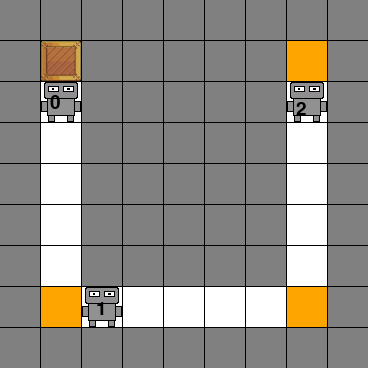

In [8]:
aec_env.reset()
Image.fromarray(aec_env.render())

Same result with parallel env

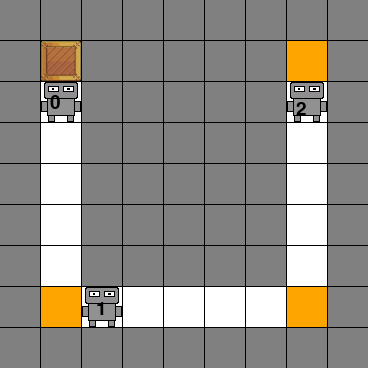

In [9]:
parallel_env.reset()
Image.fromarray(parallel_env.render())

We can list the instantiated agents in the environment (same in AEC and parallel environment)

In [10]:
print(parallel_env.agents)
aec_env.agents

['agent_0', 'agent_1', 'agent_2']


['agent_0', 'agent_1', 'agent_2']

Here, actions space is a 0 to 7 discrete space, one-hot encoding is the following:
 - 0: do nothing
 - 1: go up
 - 2: go down
 - 3: go left
 - 4: go right
 - 5: take
 - 6: drop

We can print the action space for `'agent_0'`

In [11]:
print(aec_env.action_space("agent_0"))
parallel_env.action_space("agent_0")

Discrete(7)


Discrete(7)

Here, observations space is a 3 x 3 grid (flattened) surrounding an agent, one-hot encoding for each cell is the following:
 - 0: wall
 - 1: air
 - 2: agent
 - 3: agent carrying a box
 - 4: drop zone
 - 5: box

We can print the observation space for `'agent_0'`

In [12]:
print(parallel_env.observation_space("agent_0"))
print(aec_env.observation_space("agent_0"))

MultiDiscrete([6 6 6 6 6 6 6 6 6])
MultiDiscrete([6 6 6 6 6 6 6 6 6])


In the AEC environment, agents apply their actions one after one in a cyclic way

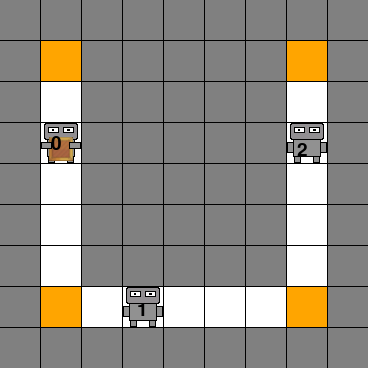

In [13]:
aec_env.reset()

# First step
aec_env.step(5) # 'agent_0' takes the box
aec_env.step(4) # 'agent_1' goes right
aec_env.step(2) # 'agent_2' goes down

# Second step
aec_env.step(2) # 'agent_0' goes down
aec_env.step(0) # 'agent_1' does nothing
aec_env.step(0) # 'agent_2' does nothing

Image.fromarray(aec_env.render())

In AEC environment, for a given agent the `last()` methods return a 5-tuple for its turn. It is composed of:
 - the current observation
 - the reward according to its last action
 - the truncation (max iteration reached for instance)
 - the done (has the game finished?)
 - the info (here contains action masks: here `'agent_0'` cannot go left, go right, take nor drop)

In [14]:
# observation, reward, termination, truncation, info = env.last()
print(aec_env.agent_selection, "receives data for its turn:")
pprint(aec_env.last())

agent_0 receives data for its turn:
(array([0, 1, 0, 0, 3, 0, 0, 1, 0]),
 5,
 False,
 False,
 {'action_masks': array([1, 1, 1, 0, 0, 0, 0], dtype=int8)})


In parallel environment, agents apply their action simultaneously at each step

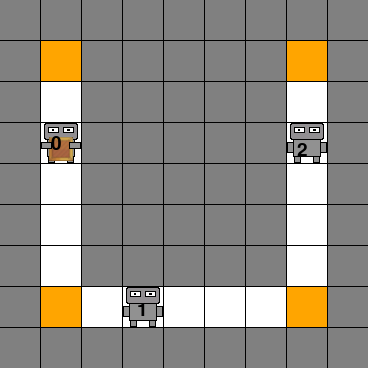

In [15]:
parallel_env.reset()

# First step
parallel_env.step({"agent_0": 5, "agent_1": 4, "agent_2": 2})

# Second step
parallel_env.step({"agent_0": 2, "agent_1": 0, "agent_2": 0})

Image.fromarray(aec_env.render())

In parallel environment, the `step()` method returns a 5-tuple composed of the data for all agent for the next step. It is composed of:
 - next observation for all agent
 - the reward for all agent
 - truncations for all agent
 - the dones for all agent
 - the infos for all agent (that may contain action masks)

In [16]:
pprint(parallel_env.step({"agent_0": 2, "agent_1": 3, "agent_2": 2}))

({'agent_0': array([0, 1, 0, 0, 3, 0, 0, 1, 0]),
  'agent_1': array([1, 0, 0, 4, 2, 1, 0, 0, 0]),
  'agent_2': array([0, 1, 0, 0, 2, 0, 0, 1, 0])},
 defaultdict(<class 'int'>, {'agent_0': 9, 'agent_1': 9, 'agent_2': 9}),
 {'agent_0': False, 'agent_1': False, 'agent_2': False},
 {'agent_0': False, 'agent_1': False, 'agent_2': False},
 {'agent_0': {'action_masks': array([1, 1, 1, 0, 0, 0, 0], dtype=int8)},
  'agent_1': {'action_masks': array([1, 0, 0, 0, 0, 0, 0], dtype=int8)},
  'agent_2': {'action_masks': array([1, 1, 1, 0, 0, 0, 0], dtype=int8)}})


### Optional: 1) Defining some OS and linking them to histories

First, we may already have some known information as for what the resulting joint-policy should look like.
For instance, we may want some agents not to play some dangerous actions at some point, or we may already
known a promising organizational form to reach the goal even though it is not yet precisely defined.

This what we are going to do leveraging links between a formal description of the organization and the
expected behavior.

#### Defining some OS

The first key concept is the Organizational Specification (OS) which represents a particular expected individual,
social or collective aspect. Organizational specifications comprise roles, links, compatibilities, goals, plans, missions, etc.

An OS is a component of the organizational model among these:
- {SS: roles, links, compatibilities, {sub-groups: SS}, role_cardinality, sub-group_cardinality}
- FS: {SCH:{goals, plans, missions, mission_to_goals, mission_to_agent_cardinality}, social_preference_order}
- DS: permissions, obligations

A single OS can be described within the organizational model with optional empty components

In [17]:
# TODO: Remove after finalizing PRAHOM package #############################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path + "/prahom_wrapper")
sys.path.append(module_path)
############################################################################

from organizational_model import organizational_model, structural_specifications

role_0_os = organizational_model(
    structural_specifications=structural_specifications(roles=["role_0"], role_inheritance_relations=None, root_groups=None), functional_specifications=None, deontic_specifications=None)

pprint(role_0_os)

organizational_model(structural_specifications=structural_specifications(roles=['role_0'],
                                                                         role_inheritance_relations=None,
                                                                         root_groups=None),
                     functional_specifications=None,
                     deontic_specifications=None)


Here `role_0_os` defines any organization where "role_0" is available for agents.
Consequently, `role_0_os` only deals with a role so it is just a singe OS.

Note:
 - "None" value indicate any value can be accepted. It can be used if you do not know additional information regarding the ones you already provided
 - If you want to express no value, you must choose {} or [] depending on the expected value format.

In [18]:
role_01_os = organizational_model(
    structural_specifications=structural_specifications(roles=["role_0", "role_1"], role_inheritance_relations={"role_1": ["role_0"]}, root_groups=None), functional_specifications=None, deontic_specifications=None)
pprint(role_01_os)

organizational_model(structural_specifications=structural_specifications(roles=['role_0',
                                                                                'role_1'],
                                                                         role_inheritance_relations={'role_1': ['role_0']},
                                                                         root_groups=None),
                     functional_specifications=None,
                     deontic_specifications=None)


Here `role_01_os` defines any organization where "role_0" and "role_1" are available for agents and we provide a known information
about these roles which is "role_1" inherits from "role_0".
If you had not do it, you could have let it to "None" and it would be then possible to infer it later.

#### Linking OS to joint-histories

The second key concept is the joint-history...
Let's recap:
- for an agent, a policy associates an observation to an action for an agent to reach a goal.
- for an agent, a history is a tuple describing sequentially all the observation-action at each step until the end of an episode
- for several agents, a joint-policy associates all the agents' observation to the agents' actions at each step enabling them to
    collectively reach their goal. It can be seen as a tuple of policies or a relation taking a vector of observation and associating
    a vector of actions.
- for several agents, a joint-history is a tuple of the agents' histories.

The underlying PRAHOM's idea, is to hypothesize if there is a specific OS among the agents' implicit organization, then their
joint-histories (obtained from a same joint-policy) should  match a specific pattern accordingly. Reversely, if some joint-histories
obtained from a same joint-policy share some common features, then the agents' implicit organization should be described into OS
defined according to these common features.

Therefore, as we may already known some OS and their expected associated behaviors, we must define all of the possible joint-histories
to describe the impact of an OS.
It is important to note, the number of agent is undefined and we do not known what OS are associated to what agent.
So, when defining associated joint-histories associated to an OS, we must be careful to keep it general.


An observation and an action are simple objects whose type is user's responsibility

In [19]:
from history_model import observation, action

obs1: observation = np.array([1, 0, 0, 4, 2, 1, 0, 0, 0])
act1: action = 4

Due to some complex observation or action types, we also define associated string shortcuts `action_label` and `observation_label`

In [20]:
from history_model import observation_label, action_label

obs_label1: observation_label = "o1"
act_label1: action_label = "a1"

It is required to define a mapping from any used label to its corresponding object

In [21]:
label_to_obj: Dict[Union[observation_label, action_label], object] = {
    "a0": 0,
    "a1": 1,
    "a2": 2,
    "a3": 3,
    "a4": 4,
    "a5": 5,
    "a6": 6,

    "o01": np.array([0, 1, 0, 0, 2, 0, 0, 1, 0]),  # 0
    "o02": np.array([0, 5, 0, 0, 2, 0, 0, 1, 0]),  # 1
    "o03": np.array([0, 4, 0, 0, 3, 0, 0, 1, 0]),  # 2
    "o04": np.array([0, 1, 0, 0, 3, 0, 0, 1, 0]),  # 2
    "o05": np.array([0, 1, 0, 0, 3, 0, 0, 4, 1]),  # 3
    "o06": np.array([0, 1, 0, 0, 3, 0, 0, 4, 2]),  # 3
    "o07": np.array([0, 1, 0, 0, 2, 0, 0, 5, 1]),
    "o08": np.array([0, 1, 0, 0, 2, 0, 0, 5, 2]),
    "o09": np.array([0, 1, 0, 0, 2, 0, 0, 4, 3]),
    "o010": np.array([0, 1, 0, 0, 2, 0, 0, 4, 1]),

    "o11": np.array([1, 0, 0, 5, 2, 1, 0, 0, 0]),  # 1
    "o12": np.array([2, 0, 0, 5, 2, 1, 0, 0, 0]),  # 1
    "o13": np.array([1, 0, 0, 4, 3, 1, 0, 0, 0]),  # 2
    "o14": np.array([2, 0, 0, 4, 3, 1, 0, 0, 0]),  # 2
    "o15": np.array([0, 0, 0, 1, 3, 1, 0, 0, 0]),  # 2
    "o16": np.array([0, 0, 0, 1, 2, 1, 0, 0, 0]),  # 0
    "o17": np.array([0, 0, 1, 1, 3, 4, 0, 0, 0]),  # 3
    "o18": np.array([0, 0, 2, 1, 3, 4, 0, 0, 0]),  # 3
    "o19": np.array([0, 0, 1, 1, 2, 5, 0, 0, 0]),
    "o110": np.array([0, 0, 2, 1, 2, 5, 0, 0, 0]),
    "o111": np.array([1, 0, 0, 4, 2, 1, 0, 0, 0]),
    "o112": np.array([3, 0, 0, 4, 2, 1, 0, 0, 0]),
    "o113": np.array([0, 0, 1, 1, 2, 4, 0, 0, 0]),
    "o114": np.array([0, 0, 3, 1, 2, 4, 0, 0, 0]),

    "o21": np.array([0, 1, 0, 0, 2, 0, 1, 5, 0]),  # 2
    "o22": np.array([0, 1, 0, 0, 2, 0, 2, 5, 0]),  # 2
    "o23": np.array([0, 1, 0, 0, 3, 0, 1, 4, 0]),  # 3
    "o24": np.array([0, 1, 0, 0, 3, 0, 2, 4, 0]),  # 3
    "o25": np.array([0, 4, 0, 0, 2, 0, 0, 1, 0]),  # 1
    "o26": np.array([0, 1, 0, 0, 2, 0, 0, 1, 0]),  # 1
    "o27": np.array([0, 1, 0, 0, 3, 0, 0, 1, 0]),  # 3
    "o28": np.array([0, 4, 0, 0, 3, 0, 0, 1, 0]),  # 1
    "o29": np.array([0, 5, 0, 0, 2, 0, 0, 1, 0]),
    "o210": np.array([0, 1, 0, 0, 2, 0, 1, 4, 0]),
    "o211": np.array([0, 1, 0, 0, 2, 0, 3, 4, 0])
}

An history is just a list of alternating obs_label and act_label

In [22]:
from history_model import history

h1: history = ["o1", "a1", "o2", "a2", "o3", "a3", "o4", "a4"]

Users can define a set of histories using the `histories` class. It gathers several histories under the form of a specific oriented graph in a compact way. It is a convenient structure to be used for training and OS inferring.

Users can create an empty `histories` as follows:

In [23]:
from history_model import histories

hg = histories()

We can add a `history` or several ones as follows

In [24]:
hg = histories()
hg.add_history(["o0", "a0", "o1", "a1", "o1", "a1", "o1", "a1", "o2", "a2"])
hg.add_histories([["o0", "a0", "o1"], ["o2", "a1", "o3"]])

We can print a graph plot representation

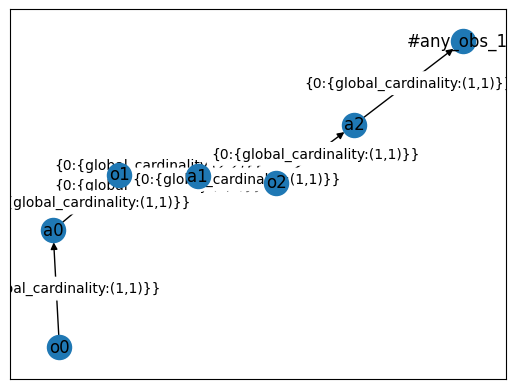

In [28]:
hg1 = histories()
hg1.add_history(["o0", "a0", "o1", "a1", "o1", "a1", "o1", "a1", "o2", "a2"])
graph_plot_rgb = hg1.generate_graph_plot(render_rgba=True, transition_data=["global_cardinality"])

# transition_data values are:
#  - ordinal_crossing (used for exhaustive description)
#  - global_cardinality, cardinalities, global_priority, priorities (used for pattern description)

# Image.fromarray(graph_plot_rgb)

We can add a `pattern_histories` object.
The pattern used is the following:
 - sequence = [sequences or labels separated by "," or "|"](multiplicity_lower_bound, multiplicity_upper_bound)
 - sequential operator ",": label_1, label_2 $\rightarrow$ label_1 is played and then label_2
 - choice operator "|": label_1, label_2 $\rightarrow$ at least either label_1 or label_2 is played

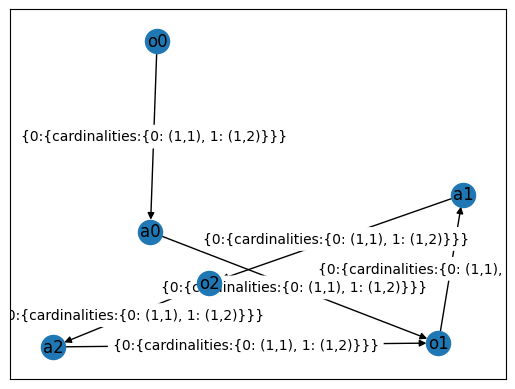

In [27]:
from history_model import histories, pattern_histories

hg = histories()

hg.add_pattern('[[o0,a0,o1](1,1),[o1,a1,o2,a2,o1](1,1)](1,2)')

graph_plot = hg.generate_graph_plot(
    render_rgba=True, transition_data=["cardinalities"])

# Image.fromarray(graph_plot)

Now, we known how to define a set of histories for a single agent, we would like to define a relation between each defined OS with a relation telling how the OS impact any subset of agents regarding their histories. It can formalized as such:

$osj: \mathcal{OS} \rightarrow \mathcal{P}(\mathcal{A}) \times \mathcal{P}(H_{joint})$

It can be understood as for any $os \in \mathcal{OS}$, among $|\mathcal{A}|$ agents only $n_{os}$ agents can be constrained to respect $os$.

Consequently, their joint-histories would have to be in $H_{joint, os}$.

Another convenient way to see $osj$ is as a relation associating any $os \in \mathcal{OS}$ to another specific relation associating the OS with the fixed arity of agents that are constrained to: $osaj: \mathcal{OS} \times \mathcal{A} \rightarrow H_{joint, \mathcal{OS}}$.

Therefore, $osj: \mathcal{OS} \rightarrow \mathcal{A} \times [osaj]$

For instance, if an OS is just a "role", then it should be associated with relation $rh: \mathcal{R} \times \mathcal{A} \rightarrow H_{joint,\mathcal{R}}$. Here $rh("agent_0", "role_0")$ would give a joint-history where "role_0" is applied to "agent_0". Here, for the obtained joint-history only the history associated to "role_0" would be constrained to be in a history subset.

### Optional: 2) Constraining agents to some OS

Once, we have defined all the relation between OS and joint-histories, we may want to use them to constrain some agents.

### 3) Training under some constraints

### 4) Inferring the refined OS